#### 导入包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import os
import sklearn.metrics as metrics
# 绘图防止中文出错
sns.set(font="SimHei", font_scale=1.5)
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

#### 导入数据

In [2]:
data=pd.read_excel("/workspaces/LCBIO/建模数据/data1b.xlsx")
x=data.iloc[:,2:-1]
y=data["是否血肿"]
Xtrain,Xtest,Ytrain,Ytest=train_test_split(x,y,test_size=0.2,random_state=420)

In [3]:
(Xtrain.isnull().sum(axis=0) /
             Xtrain.shape[0]).sort_values(ascending=False).head(30), Xtrain.columns

(年龄                                                      0.0
 性别                                                      0.0
 original_shape_Sphericity                               0.0
 original_shape_MinorAxisLength                          0.0
 original_shape_MeshVolume                               0.0
 original_shape_Maximum3DDiameter                        0.0
 original_shape_Maximum2DDiameterSlice                   0.0
 original_shape_Maximum2DDiameterRow                     0.0
 original_shape_Maximum2DDiameterColumn                  0.0
 original_shape_MajorAxisLength                          0.0
 original_shape_LeastAxisLength                          0.0
 original_shape_Flatness                                 0.0
 original_shape_Elongation                               0.0
 ED_Cerebellum_L_Ratio                                   0.0
 ED_Pons_Medulla_L_Ratio                                 0.0
 ED_PCA_L_Ratio                                          0.0
 ED_MCA_L_Ratio         

#### 特征工程

In [4]:
#评估器为随机森林的递归特征选择法即包装法
from sklearn.ensemble import RandomForestClassifier as RFC_  #分类器
from sklearn.feature_selection import RFE  #递归特征消除法

rf=RFC_(random_state=42)
rf=rf.fit(Xtrain,Ytrain)

selector_RFE = RFE(rf,
                   n_features_to_select=5,
                   step=1
                  ).fit(Xtrain, Ytrain)


#over_x.columns[selector_RFE.get_support()]
Xtrain.columns[selector_RFE.get_support()]

Index(['original_shape_Elongation', 'original_shape_MinorAxisLength',
       'NCCT_original_firstorder_Entropy',
       'NCCT_original_firstorder_InterquartileRange',
       'NCCT_original_firstorder_RobustMeanAbsoluteDeviation'],
      dtype='object')

In [5]:
Xtrain=Xtrain[['original_shape_Elongation', 'original_shape_MinorAxisLength',
       'NCCT_original_firstorder_Entropy',
       'NCCT_original_firstorder_InterquartileRange',
       'NCCT_original_firstorder_RobustMeanAbsoluteDeviation']]
Xtest=Xtest[['original_shape_Elongation', 'original_shape_MinorAxisLength',
       'NCCT_original_firstorder_Entropy',
       'NCCT_original_firstorder_InterquartileRange',
       'NCCT_original_firstorder_RobustMeanAbsoluteDeviation']]

In [6]:
X=data[['original_shape_Elongation', 'original_shape_MinorAxisLength',
       'NCCT_original_firstorder_Entropy',
       'NCCT_original_firstorder_InterquartileRange',
       'NCCT_original_firstorder_RobustMeanAbsoluteDeviation']]

#### SVM

In [7]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
# 创建SVM分类器
SVM = svm.SVC(probability=True)
# 训练分类器
SVM.fit(Xtrain,Ytrain)

#评估
from sklearn.metrics import accuracy_score
SVM.decision_function(Xtest)
SVM.decision_function(Xtrain)
pre_test = (SVM.decision_function(Xtest) > 0).astype(int)
pre_train = (SVM.decision_function(Xtrain) > 0).astype(int)
train_score = accuracy_score(Ytrain,pre_train)
print('train_score',train_score)
test_score = accuracy_score(Ytest, pre_test)
print('test_score',test_score)

test_predict3 = pre_test
#print(test_predict)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

conf = confusion_matrix(Ytest, test_predict3)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:', accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:', sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:', speciality)
#F1分数：
F1_score = 2 * conf[1, 1] / (2 * conf[1, 1] + conf[1, 0] + conf[0, 1])
print('F1_score:', F1_score)
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:', FDR)

score=SVM.decision_function(Xtest)
predict = SVM.predict(Xtest)
fpr, tpr, thres = roc_curve(Ytest,score)

print("AUC:", roc_auc_score(Ytest, score))
print('Cross-entropy loss:', metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(SVM, Xtrain, Ytrain,cv=10)
scores.mean()

train_score 0.725
test_score 0.95
accuracy: 0.95
sensitivity: 0.0
speciality: 1.0
F1_score: 0.0
FDR: nan
AUC: 0.8421052631578947
Cross-entropy loss: 1.8021826694558576


/tmp/ipykernel_51769/1547414107.py:41: RuntimeWarning: invalid value encountered in scalar divide
  FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])


0.725

#### XGBoost

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier as XGBC

from xgboost.sklearn import XGBClassifier
XGB = XGBClassifier(min_child_weight=0.1,max_depth=5,reg_alpha=0.001)

XGB.fit(Xtrain,Ytrain) ##拟合模型

from sklearn.metrics import accuracy_score
train_score = accuracy_score(Ytrain,XGB.predict(Xtrain))
print('train_score',train_score)
test_score = accuracy_score(Ytest,XGB.predict(Xtest))
print('test_score',test_score)

test_predict4=XGB.predict(Xtest)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

conf = confusion_matrix(Ytest, test_predict4)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:',accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:',sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:',speciality)
#F1分数：
F1_score = 2*conf[1, 1] / (2*conf[1, 1]+conf[1, 0] + conf[0, 1])
print('F1_score:',F1_score) 
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:',FDR)

score = XGB.predict_proba(Xtest)[:,1]
predict = XGB.predict(Xtest)
fpr,tpr,thres = roc_curve(Ytest,score)

print("AUC:",roc_auc_score(Ytest, score, average='macro', sample_weight=None))
print('Cross-entropy loss:',metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(XGB,Xtrain,Ytrain,cv=10)
scores.mean()

train_score 1.0
test_score 0.9
accuracy: 0.9
sensitivity: 1.0
speciality: 0.8947368421052632
F1_score: 0.5
FDR: 0.6666666666666666
AUC: 1.0
Cross-entropy loss: 0.15846530815192766


/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

0.6375

In [9]:
df1=XGB.predict_proba(X)
df = pd.DataFrame(df1, columns=["类别 0 概率", "类别 1 概率"])
df.to_excel("xgb概率估计结果.xlsx")

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

### 线性判别分析

In [10]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis() 
LDA.fit(Xtrain,Ytrain) ##拟合模型

#评估
from sklearn.metrics import accuracy_score
# 计算训练集和测试集的准确率
train_accuracy = accuracy_score(Ytrain,LDA.predict(Xtrain))
print('accuracy-train',train_accuracy)
accuracy_test = accuracy_score(Ytest,LDA.predict(Xtest))
print('accuracy-test',accuracy_test)

test_predict1=LDA.predict(Xtest)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

# 计算混淆矩阵
cm=confusion_matrix(Ytest, test_predict1)

# 另一种=方式计算precision, recall, F1-score, support, 输出结果为0和1不同类的结果
pre, rec, f1, sup = precision_recall_fscore_support(Ytest, test_predict1,labels=[1,0])
print("precision:", pre, "\nrecall:", rec, "\nf1-score:", f1, "\nsupport:", sup) 

p = precision_score(Ytest, test_predict1, average='binary')
print("precision:",p)
r = recall_score(Ytest, test_predict1, average='binary')
f1score = f1_score(Ytest, test_predict1, average='binary')

conf = confusion_matrix(Ytest, test_predict1)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:',accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:',sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:',speciality)
#F1分数：
F1_score = 2*conf[1, 1] / (2*conf[1, 1]+conf[1, 0] + conf[0, 1])
print('F1_score:',F1_score) 
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:',FDR)

score = LDA.predict_proba(Xtest)[:,1]
predict = LDA.predict(Xtest)
fpr,tpr,thres = roc_curve(Ytest,score,)

print("AUC:",roc_auc_score(Ytest, score, average='macro', sample_weight=None))
print('Cross-entropy loss:', metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(LDA, Xtrain, Ytrain,cv=10)
scores.mean()

accuracy-train 0.725
accuracy-test 0.95
precision: [0.   0.95] 
recall: [0. 1.] 
f1-score: [0.         0.97435897] 
support: [ 1 19]
precision: 0.0
accuracy: 0.95
sensitivity: 0.0
speciality: 1.0
F1_score: 0.0
FDR: nan
AUC: 1.0
Cross-entropy loss: 0.28970630854876783


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_51769/2376338387.py:46: RuntimeWarning: invalid value encountered in scalar divide
  FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])


0.6625

### 随机森林

In [11]:
from sklearn.ensemble import RandomForestClassifier  #分类器

RF = RandomForestClassifier(n_estimators=170,random_state=42)  #训练100个基分类器
RF.fit(Xtrain, Ytrain)  ##拟合模型

#评估
from sklearn.metrics import accuracy_score
train_score = accuracy_score(Ytrain,RF.predict(Xtrain))
print('train_score',train_score)
test_score = accuracy_score(Ytest, RF.predict(Xtest))
print('test_score',test_score)
test_predict = RF.predict(Xtest)
#print(test_predict)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  roc_curve, auc, roc_auc_score

conf = confusion_matrix(Ytest, test_predict)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:', accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:', sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:', speciality)
#F1分数：
F1_score = 2 * conf[1, 1] / (2 * conf[1, 1] + conf[1, 0] + conf[0, 1])
print('F1_score:', F1_score)
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:', FDR)

score = RF.predict_proba(Xtest)[:, 1]
predict = RF.predict(Xtest)
fpr, tpr, thres = roc_curve(Ytest,score)

print("AUC:", roc_auc_score(Ytest, score, average='macro', sample_weight=None))
print('Cross-entropy loss:', metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(RF, Xtrain, Ytrain,cv=10)
scores.mean()

train_score 1.0
test_score 0.95
accuracy: 0.95
sensitivity: 0.0
speciality: 1.0
F1_score: 0.0
FDR: nan
AUC: 0.9736842105263158
Cross-entropy loss: 0.27572752242413384


/tmp/ipykernel_51769/3929798977.py:34: RuntimeWarning: invalid value encountered in scalar divide
  FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])


0.6875

### GBDT

In [12]:
from sklearn.ensemble import GradientBoostingClassifier #GBDT算法
GBDT = GradientBoostingClassifier() 

GBDT.fit(Xtrain,Ytrain) ##拟合模型

from sklearn.metrics import accuracy_score
train_score = accuracy_score(Ytrain,GBDT.predict(Xtrain))
print('train_score',train_score)
test_score = accuracy_score(Ytest,GBDT.predict(Xtest))
print('test_score',test_score)

test_predict5=GBDT.predict(Xtest)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

conf = confusion_matrix(Ytest, test_predict5)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:',accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:',sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:',speciality)
#F1分数：
F1_score = 2*conf[1, 1] / (2*conf[1, 1]+conf[1, 0] + conf[0, 1])
print('F1_score:',F1_score) 
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:',FDR)

score = GBDT.predict_proba(Xtest)[:,1]
predict = GBDT.predict(Xtest)
fpr,tpr,thres = roc_curve(Ytest,score)

print("AUC:",roc_auc_score(Ytest, score, average='macro', sample_weight=None))
print('Cross-entropy loss:',metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(GBDT,Xtrain,Ytrain,cv=10)
scores.mean()

train_score 1.0
test_score 0.95
accuracy: 0.95
sensitivity: 1.0
speciality: 0.9473684210526315
F1_score: 0.6666666666666666
FDR: 0.5
AUC: 0.9473684210526316
Cross-entropy loss: 0.20985360025097957


0.6625

### ADAboost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
ADA=AdaBoostClassifier().fit(Xtrain,Ytrain)#实例化

from sklearn.metrics import accuracy_score
train_score = accuracy_score(Ytrain,ADA.predict(Xtrain))
print('train_score',train_score)
test_score = accuracy_score(Ytest,ADA.predict(Xtest))
print('test_score',test_score)

test_predict6=ADA.predict(Xtest)

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

conf = confusion_matrix(Ytest, test_predict6)
accuracy = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
print('accuracy:',accuracy)
#accuracy.append(accuracy)
sensitivity = conf[1, 1] / (conf[1, 0] + conf[1, 1])
print('sensitivity:',sensitivity)
#特异度：
speciality = conf[0, 0] / (conf[0, 1] + conf[0, 0])
print('speciality:',speciality)
#F1分数：
F1_score = 2*conf[1, 1] / (2*conf[1, 1]+conf[1, 0] + conf[0, 1])
print('F1_score:',F1_score) 
#FDR：
FDR = conf[0, 1] / (conf[0, 1] + conf[1, 1])
print('FDR:',FDR)

score = ADA.predict_proba(Xtest)[:,1]
predict = ADA.predict(Xtest)
fpr,tpr,thres = roc_curve(Ytest,score)

print("AUC:",roc_auc_score(Ytest, score, average='macro', sample_weight=None))
print('Cross-entropy loss:',metrics.log_loss(Ytest, score))

#交叉验证
scores = cross_val_score(ADA,Xtrain,Ytrain,cv=10)
scores.mean()

train_score 1.0
test_score 0.9
accuracy: 0.9
sensitivity: 1.0
speciality: 0.8947368421052632
F1_score: 0.5
FDR: 0.6666666666666666
AUC: 0.9473684210526316
Cross-entropy loss: 0.5656340577666183


0.7

### ROC_curve

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roma

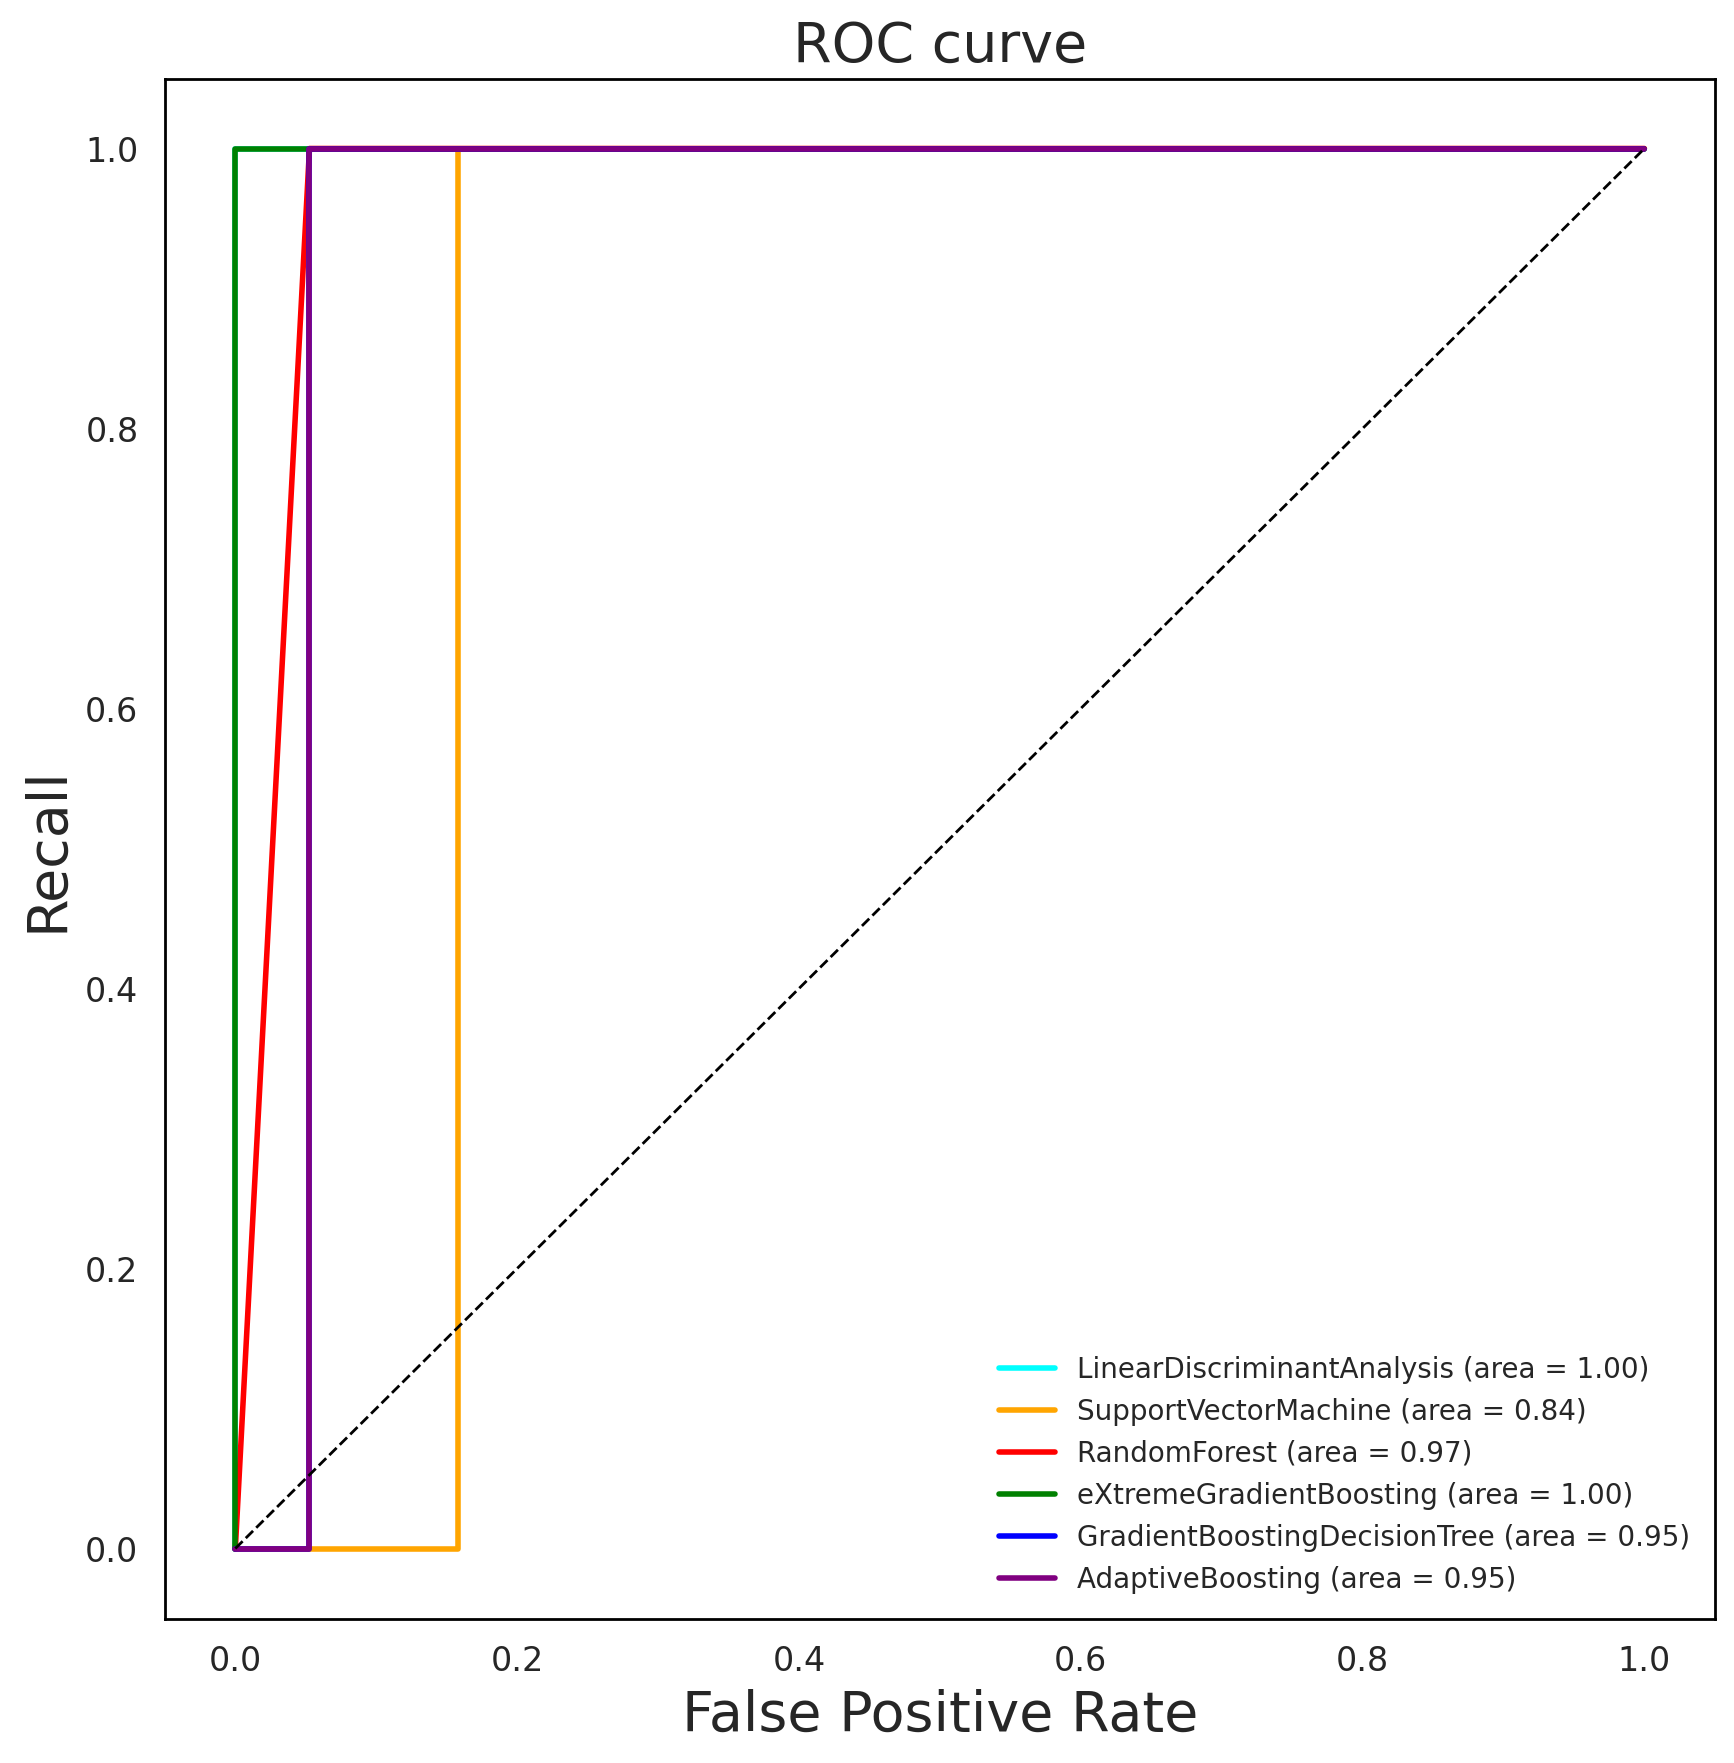

In [14]:
from sklearn.metrics import roc_curve
FPR1,recall1,thresholds1=roc_curve(Ytest,LDA.predict_proba(Xtest)[:,1],pos_label=1)
FPR3,recall3,thresholds3=roc_curve(Ytest,SVM.decision_function(Xtest),pos_label=1)
FPR,recall,thresholds=roc_curve(Ytest,RF.predict_proba(Xtest)[:,1],pos_label=1)
FPR4,recall4,thresholds4=roc_curve(Ytest,XGB.predict_proba(Xtest)[:,1],pos_label=1)
FPR5,recall5,thresholds5=roc_curve(Ytest,GBDT.predict_proba(Xtest)[:,1],pos_label=1)
FPR6,recall6,thresholds6=roc_curve(Ytest,ADA.predict_proba(Xtest)[:,1],pos_label=1)

from sklearn.metrics import roc_auc_score as auc
area1=auc(Ytest,LDA.predict_proba(Xtest)[:,1])
area3=auc(Ytest,SVM.decision_function(Xtest))
area=auc(Ytest,RF.predict_proba(Xtest)[:,1])
area4=auc(Ytest,XGB.predict_proba(Xtest)[:,1])
area5=auc(Ytest,GBDT.predict_proba(Xtest)[:,1])
area6=auc(Ytest,ADA.predict_proba(Xtest)[:,1])

fig=plt.figure(figsize=(10,10),dpi=200,facecolor='white')
ax=plt.gca()
ax.set_facecolor('none')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(1.0)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.0)

plt.plot(FPR1, recall1, color='cyan',
         label='LinearDiscriminantAnalysis (area = %0.2f)'% area1 ,linewidth=2.0)
plt.plot(FPR3, recall3, color='orange',
         label='SupportVectorMachine (area = %0.2f)'% area3 ,linewidth=2.0)
plt.plot(FPR, recall, color='red',
         label='RandomForest (area = %0.2f)'% area  ,linewidth=2.0)
plt.plot(FPR4, recall4, color='green',
         label='eXtremeGradientBoosting (area = %0.2f)'% area4  ,linewidth=2.0)
plt.plot(FPR5, recall5, color='blue',
         label='GradientBoostingDecisionTree (area = %0.2f)' % area5 ,linewidth=2.0)
plt.plot(FPR6, recall6, color='purple',
         label='AdaptiveBoosting (area = %0.2f)' % area6 ,linewidth=2.0)
plt.plot([0, 1], [0, 1], color='black', linestyle='--' ,linewidth=1.0)

font={'family':'Times New Roman', 
      'weight':'normal',
      'size':20
     }
font2={'family':'Times New Roman', 
      'weight':'normal',
      'size':10
     }
plt.gca().set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=12)                      # 坐标轴上的标尺的字的大小 
plt.yticks(fontsize=12)
plt.xlabel('False Positive Rate',fontdict=font)
plt.ylabel('Recall',fontdict=font)
plt.title('ROC curve',fontdict={'family':'Times New Roman',  'weight':'normal', 'size':20})
plt.legend(loc="lower right",prop = font2,facecolor='w',edgecolor='w');
#plt.grid(True,color='black',linestyle='--',alpha=0.1);
plt.savefig("1broc3.jpg")

### PR_curve

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: 

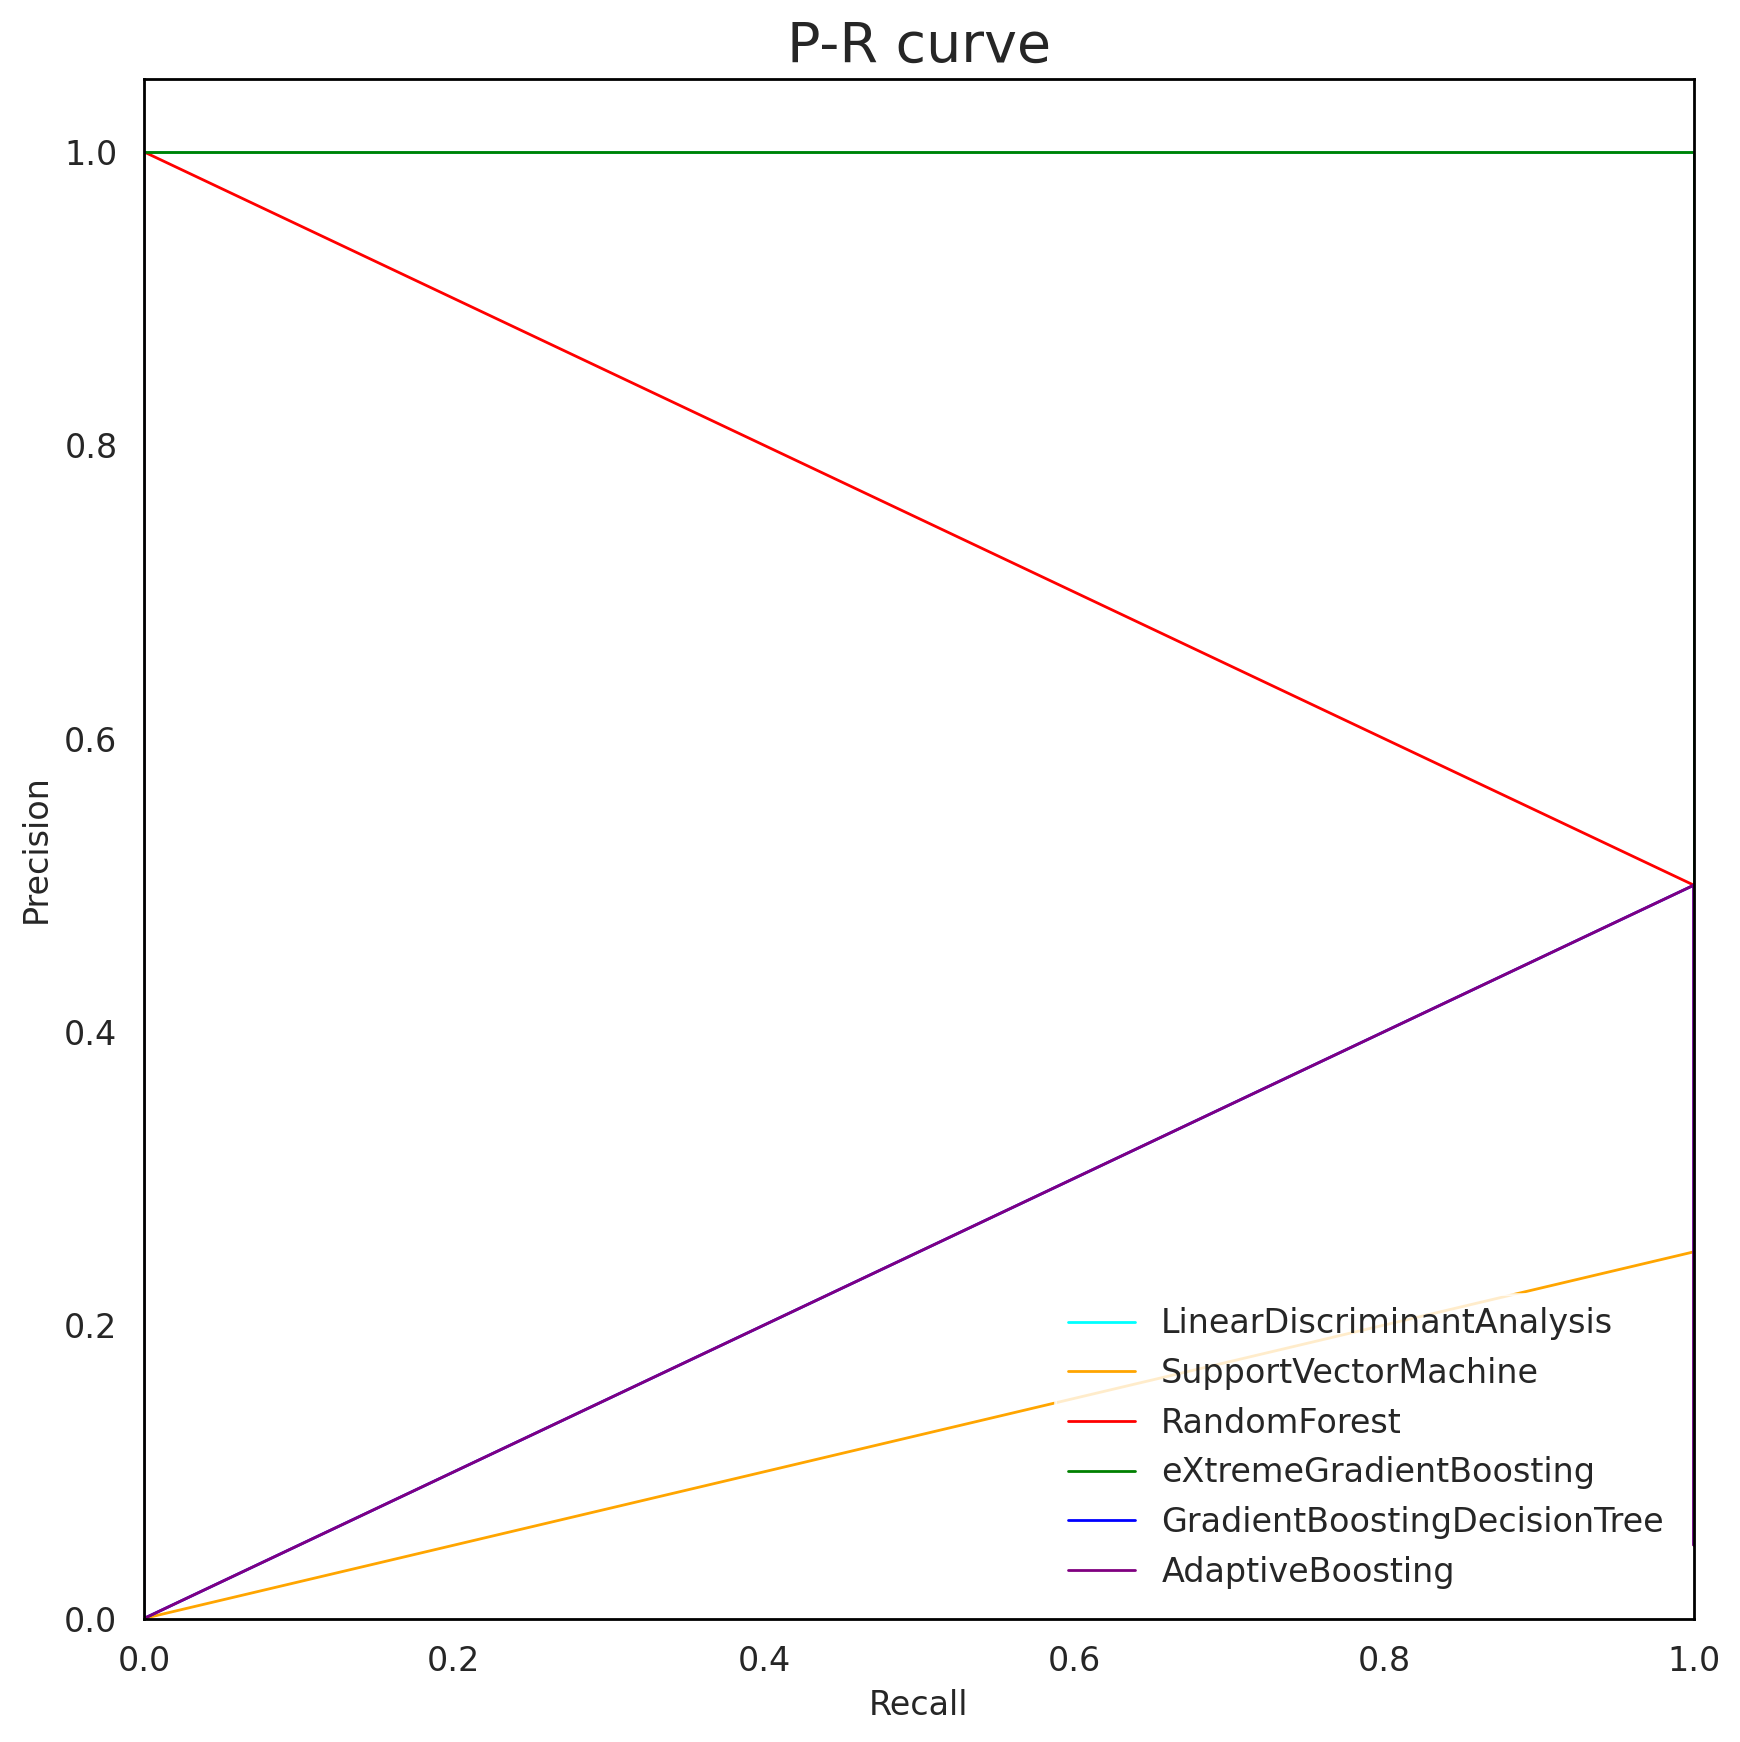

In [15]:
from sklearn.metrics import precision_recall_curve

fig=plt.figure(figsize=(10,10),dpi=200,facecolor='w')
ax=plt.gca()
ax.set_facecolor('none')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(1.0)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.0)

precision1,recall1,_ = precision_recall_curve(Ytest,LDA.predict_proba(Xtest)[:,1])
precision3,recall3,_ = precision_recall_curve(Ytest,SVM.predict_proba(Xtest)[:,1])
precision,recall,_ = precision_recall_curve(Ytest,RF.predict_proba(Xtest)[:,1])
precision4,recall4,_ = precision_recall_curve(Ytest,XGB.predict_proba(Xtest)[:,1])
precision5,recall5,_ = precision_recall_curve(Ytest,GBDT.predict_proba(Xtest)[:,1])
precision6,recall6,_ = precision_recall_curve(Ytest,ADA.predict_proba(Xtest)[:,1])

plt.plot(recall1,precision1,color="cyan",label="LinearDiscriminantAnalysis",linewidth=1.0)
plt.plot(recall3,precision3,color="orange",label="SupportVectorMachine",linewidth=1.0)
plt.plot(recall,precision,color="red",label="RandomForest",linewidth=1.0)
plt.plot(recall4,precision4,color="green",label="eXtremeGradientBoosting",linewidth=1.0)
plt.plot(recall5,precision5,color="blue",label="GradientBoostingDecisionTree",linewidth=1.0)
plt.plot(recall6,precision6,color="purple",label="AdaptiveBoosting",linewidth=1.0)

#plt.fill_between(recall,precision,step="post",alpha=0.2,color="#48a6ff")

font={'family':'Times New Roman', 
      'weight':'normal',
      'size':12
     }
plt.xlabel("Recall",fontdict=font)
plt.ylabel("Precision",fontdict=font)
plt.xticks(fontsize=12)                      # 坐标轴上的标尺的字的大小 
plt.yticks(fontsize=12)
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('P-R curve',fontdict={'family':'Times New Roman',  'weight':'normal', 'size':20})
plt.legend(loc="lower right",prop = font,facecolor='w',edgecolor='w')
plt.grid(False);
#plt.savefig(r'1bpr.jpg')

### confusion_matrix

/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfon

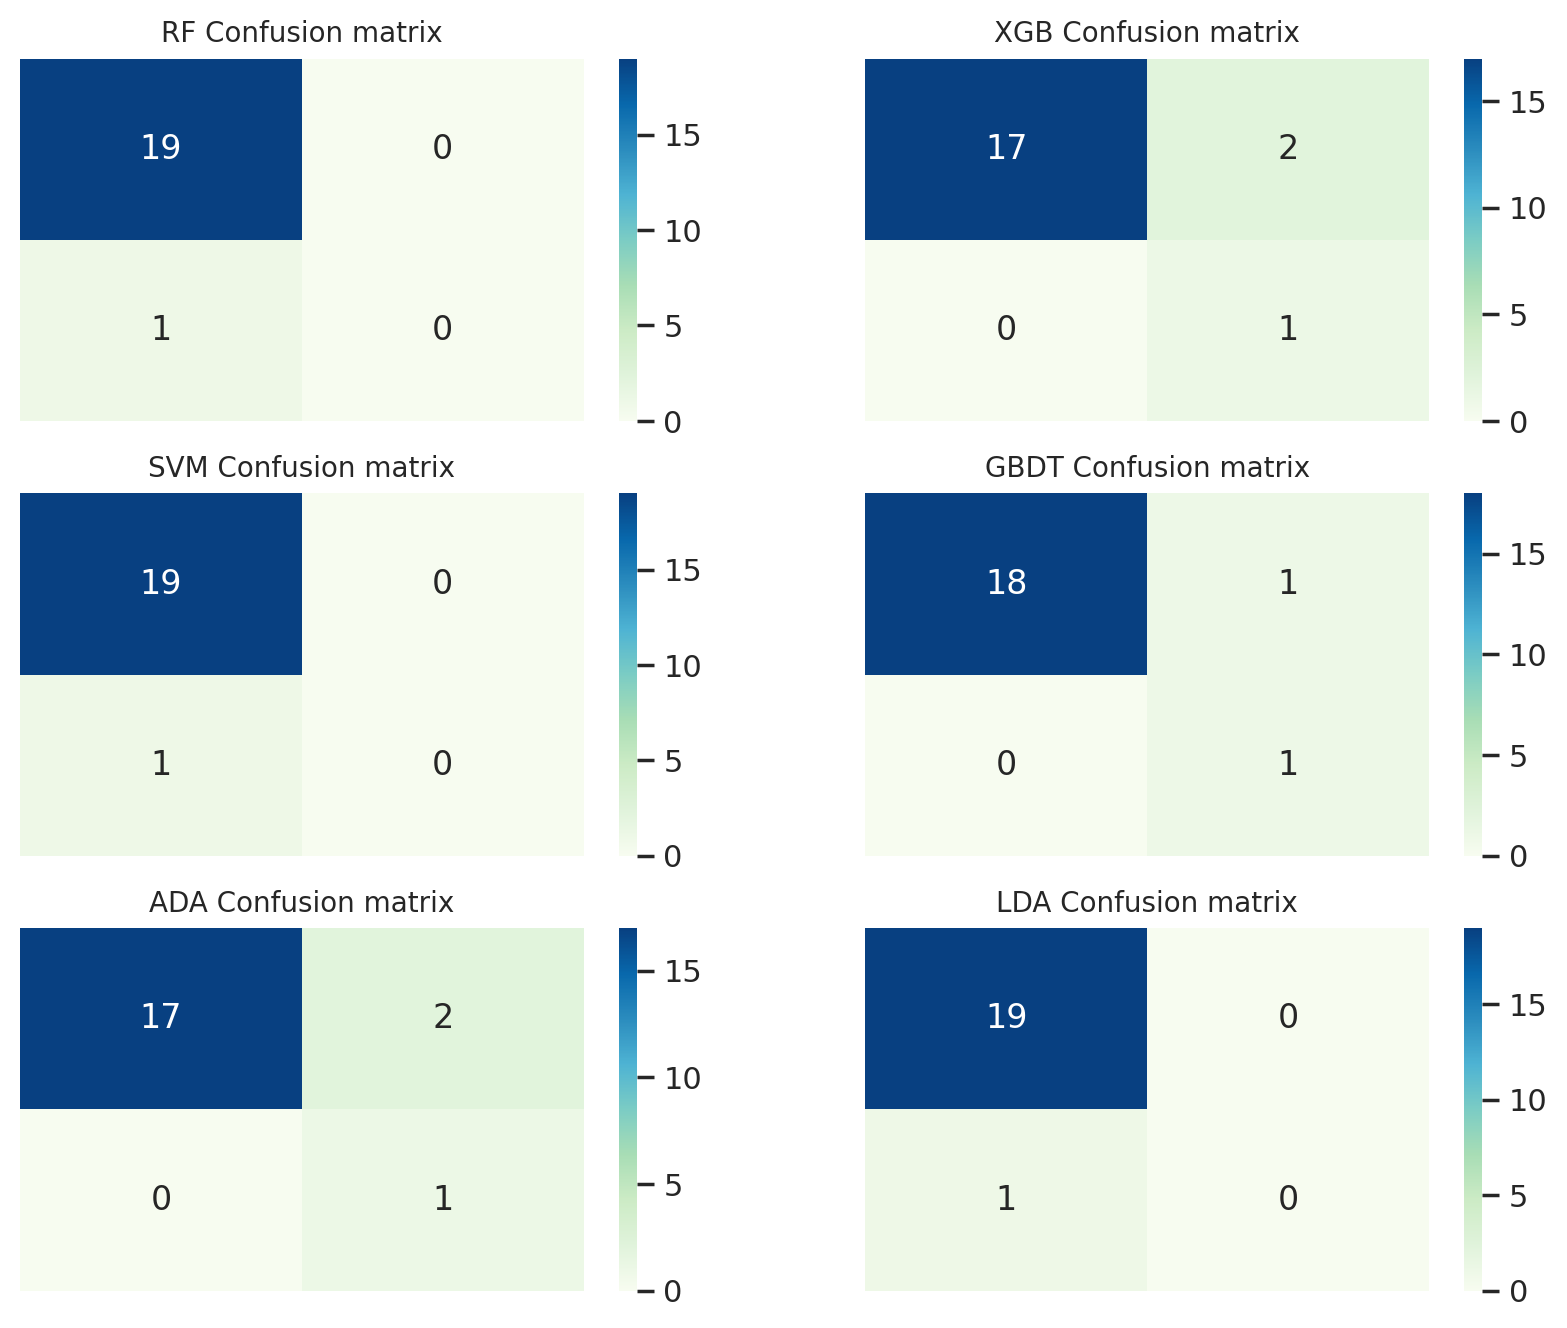

In [16]:
from sklearn.metrics import confusion_matrix as CM

y_pred_RF =RF.predict(Xtest)
y_pred_XGB=XGB.predict(Xtest)
y_pred_GBDT=GBDT.predict(Xtest)
y_pred_ADAB=ADA.predict(Xtest)
y_pred_SVC=SVM.predict(Xtest)
y_pred_LDA=LDA.predict(Xtest)


RF=CM(Ytest,y_pred_RF)
XGB=CM(Ytest,y_pred_XGB)
GBDT=CM(Ytest,y_pred_GBDT)
ADAB=CM(Ytest,y_pred_ADAB)
SVM=CM(Ytest,y_pred_SVC)
LDA=CM(Ytest,y_pred_LDA)

plt.figure(figsize=(10,8),dpi=200)
#fig,ax=plt.subplots(3,3,figsize=(10,10),dpi=200)
sns.set(font="SimHei",font_scale=1.0)

font={'family':'Times New Roman', 
    'weight':'normal',
      'size':10
}

ax1=plt.subplot(3,2,1)
#sns.heatmap(RF,ax=ax[0][0],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(RF,ax=ax1,annot=True,cmap=plt.cm.GnBu)
ax1.set_title("RF Confusion matrix",fontdict=font)
ax1.set_xticklabels(['',''],fontsize=8,rotation=90)
ax1.set_yticklabels(['',''],fontsize=8,rotation=360)

ax2=plt.subplot(3,2,2)
#sns.heatmap(XGB,ax=ax[0][1],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(XGB,ax=ax2,annot=True,cmap=plt.cm.GnBu)
ax2.set_title("XGB Confusion matrix",fontdict=font)
ax2.set_xticklabels(['',''],fontsize=8,rotation=90)
ax2.set_yticklabels(['',''],fontsize=8,rotation=360)

ax3=plt.subplot(3,2,3)
#sns.heatmap(GBDT,ax=ax[0][2],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(SVM,ax=ax3,annot=True,cmap=plt.cm.GnBu)
ax3.set_title("SVM Confusion matrix",fontdict=font)
ax3.set_xticklabels(['',''],fontsize=8,rotation=90)
ax3.set_yticklabels(['',''],fontsize=8,rotation=360)

ax4=plt.subplot(3,2,4)
#ns.heatmap(SVM,ax=ax[1][0],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(GBDT,ax=ax4,annot=True,cmap=plt.cm.GnBu)
ax4.set_title("GBDT Confusion matrix",fontdict=font)
ax4.set_xticklabels(['',''],fontsize=8,rotation=90)
ax4.set_yticklabels(['',''],fontsize=8,rotation=360)

ax5=plt.subplot(3,2,5)
#sns.heatmap(ADAB,ax=ax[1][1],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(ADAB,ax=ax5,annot=True,cmap=plt.cm.GnBu)
ax5.set_title("ADA Confusion matrix",fontdict=font)
ax5.set_xticklabels(['',''],fontsize=8,rotation=90)
ax5.set_yticklabels(['',''],fontsize=8,rotation=360)

ax6=plt.subplot(3,2,6)
#sns.heatmap(LDA,ax=ax[1][2],annot=True,cmap=plt.cm.GnBu)
sns.heatmap(LDA,ax=ax6,annot=True,cmap=plt.cm.GnBu)
ax6.set_title("LDA Confusion matrix",fontdict=font)
ax6.set_xticklabels(['',''],fontsize=8,rotation=90)
ax6.set_yticklabels(['',''],fontsize=8,rotation=360);
plt.savefig('1b混淆矩阵2.jpg')
